# This notebook contains everything needed to make all plots for the QPS paper.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, compiler, circuit, compiler
import math
import time
import sys
import matplotlib.pyplot as plt
import matplotlib

sys.path.append('../')
sys.path.append('../data/')
sys.path.append('../plots/')

# Local imports
import QuantumPartonShower as qpso # old algo
import QuantumPartonShower_ReM as qpsc # improved algo
import plotting as pl
import MakeObservables as mo

## Define variables to be used throughout the notebook

In [3]:
eps= 0.001
g_1= 2
g_2= 1
nI= 1
iP= ['101'] # one 1-fermion

## Gate counting

### Note: counting the gates in QuantumCircuits with c_if's does not work, as all gates with classical conditioning are counting when in an actual implementation, just one of the gates is selected and applied. There is a special file for doing this though -- QuantumPartonShower_ReM_GateCounting.py -- where gates with mutually exclusive classical controls are removed, such that the correct number (1) of gates are added to the total.

## Define functions that compute gate counts (mid-circuit measurements)

In [4]:
def grayList(L):
    if L == 1:
        return np.ones(1)
    else:
        return np.concatenate((grayList(L-1), np.ones(1), 1 + grayList(L-1)), 0)


def gate_counter_TLCry(L, k):
    glk= grayList(L)[k-1]
    return 14 + 12*(2*glk - 1)*(L - 2) + 2*(glk - 1)
    

def gate_counter(n_i, N):
    count_uCount= 0
    count_Ue= 0
    count_Uh= 0
    count_Up= 0
    count_R= 0

    for m in range(0, N):
        # Step-dependent params
        L= int(math.ceil(math.log2(n_i + m + 1)))
        nf= n_i + m - 1 + int(m % 2 == 0)
        
        # Rotations
        count_R+= 4*(n_i + m + 1)

        # Ucount
        if L > 1:
            count_uCount+= (13*L)*(n_i + m) # Adders
        else:
            count_uCount+= (13*L)*(n_i + m) + 6 # Adders
        
        # Ue
        count_Ue+= (12*L - 10) * (nf + 1)

        # Uh
        count_Uh+= 12*L - 11
        for k in range(1, n_i + m + 1):
            lk= int(math.ceil(math.log2(k + 1)))
            
            if k <= n_i:
                nf_lk= k
            else:
                nf_lk= k - int((k-n_i) % 2 != 0)

            # with reduced registers
            #count_Uh+= 13*lk + nf_lk*(120 + 12*lk + 3*gate_counter_TLCry(L, k))
            # with full L registers
            count_Uh+= 13*L + (nf_lk+1)*(120 + 12*L + 3*gate_counter_TLCry(L, k))

        count_Uh= int(count_Uh)
        if L == 1: # the extra CCX from minus1 with m= 0
            count_Uh+= 6

        # Up
        count_Up+= 2
        
    return count_uCount, count_Ue, count_Uh, count_Up, count_R

### Count gates costs of the original circuits, using QuantumCircuits

In [6]:
# Note, these are already computed, and stored in 'cx_naive.py'. Just load them in the cell below. (Or recompute them here.)

Nmax= 4

cx_naive= np.zeros(Nmax-1)
for n in range(1, Nmax):
    qps1= qpso.QuantumPartonShower(n, 1, g_1, g_2, 1, eps)
    qc, qubits= qps1.createCircuit(iP)

    print('Qubits: ' + str(qc.num_qubits))
    print('Clbits: ' + str(qc.num_clbits))
    print('Gates: ' + str(qc.count_ops()))
    
    # Not necessary, but can double check using:
    #qcT= compiler.transpile(qc, basis_gates=['u1', 'u2', 'u3', 'h', 'z', 'y', 'x', 'ry', 'rz', 'rx', 'cx'], optimization_level= 1)
    #print('Transpiled Gates: ' + str(qcT.count_ops()))
    #cx_naive[n]= qcT.count_ops()['cx']
    
    ops= qc.count_ops()
    cx_naive[n-1]= int(ops['cx'] + 6*ops['ccx'] + ops['ch'] + 2*ops['cry']) 
    print('CX Gates: ' + str(cx_naive[n-1]))

save= False
if save:
    np.save('./data/cx_naive', cx_naive)

generated circuit on 20 qubits
Qubits: 20
Clbits: 0
Gates: OrderedDict([('ccx', 155), ('x', 127), ('cry', 17), ('cx', 7), ('ch', 1)])
CX Gates: 972.0
generated circuit on 33 qubits
Qubits: 33
Clbits: 0
Gates: OrderedDict([('ccx', 1099), ('x', 926), ('cry', 75), ('cx', 32), ('ch', 3)])
CX Gates: 6779.0
generated circuit on 38 qubits
Qubits: 38
Clbits: 0
Gates: OrderedDict([('ccx', 3352), ('x', 2747), ('cry', 208), ('cx', 93), ('ch', 6)])
CX Gates: 20627.0


## Count gates of the ReM circuits, and save

In [7]:
N= 17 # Compute 1..N steps, < Nmax from previous cell
n= 9 # Plot 1..n steps

Narray= np.arange(1, N)
uCount= np.zeros(N-1)
Ue= np.zeros(N-1)
Uh= np.zeros(N-1)
Up= np.zeros(N-1)
R= np.zeros(N-1)

for j in range(1, N):
    uCount[j-1], Ue[j-1], Uh[j-1], Up[j-1], R[j-1]= gate_counter(1, j)

total= uCount + Ue + Uh + Up + R

# Save ReM counts
save= False
if save:
    np.save('./data/cx_ReM', total)

### Plot and save

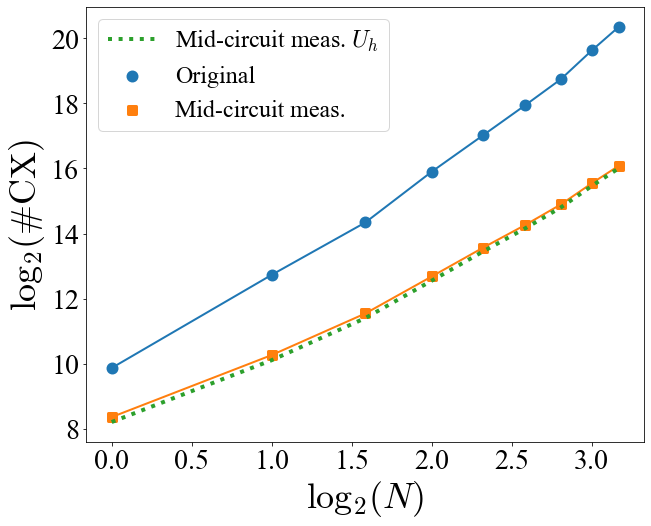

In [8]:
# Total log gates counts:

N= 17 # Compute 1..N steps, < Nmax from previous cell
n= 9 # Plot 1..n steps

plt.figure(figsize=(10, 8))
plt.rcParams['mathtext.fontset'] = 'cm'

# Either load the original counts from cx_naive.npy, or compute them in the previous cell
load= True
if load:
    cx_naive= np.load('./data/cx_naive.npy')
    cx_ReM= np.load('./data/cx_ReM.npy')

plt.plot(np.log2(Narray[:n]), np.log2(cx_naive[:n]), linewidth= 2)
plt.plot(np.log2(Narray[:n]), np.log2(total[:n]), linewidth= 2)
plt.plot(np.log2(Narray[:n]), np.log2(Uh[:n]), linewidth= 4, linestyle= ':', label=r'Mid-circuit meas. $U_h$')
plt.scatter(np.log2(Narray[:n]), np.log2(cx_naive[:n]), linewidth= 3, marker='o', s=80, label='Original')
plt.scatter(np.log2(Narray[:n]), np.log2(total[:n]), linewidth= 3, marker='s', s=80, label='Mid-circuit meas.')
#plt.scatter(np.log2(Narray[:n]), np.log2(Uh[:n]), linewidth= 3, linestyle= ':', label=r'Mid-circuit meas. $U_h$')
plt.xlabel(r'$\log_2(N)$', fontname= 'times new roman', fontsize= 36)
plt.ylabel(r'$\log_2(\#\mathrm{CX})$', fontname= 'times new roman', fontsize= 36)
plt.xticks(size= 28, fontname= 'times new roman')
plt.yticks(size= 28, fontname= 'times new roman')
plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 24))

save= False
if save:
    plt.savefig('./plots/fig5_gate_count.pdf')
plt.show()

## Qubit counting

### Define functions that compute qubits counts

In [10]:
def qubit_count_new(N, ni):
    return int(2*(N+ni) + 4*math.ceil(math.log2(N+ni)) + 2)

def qubit_count_original(N, ni):
    return int(3*(N+ni) + 7*math.ceil(math.log2(N+ni)) + 6 + np.sum(np.ceil(np.log2(np.arange(0, N) + ni + 1))))

### Plot and save

N: 1,    orig: 20,     new: 10
N: 2,    orig: 32,     new: 16
N: 3,    orig: 37,     new: 18
N: 4,    orig: 50,     new: 24
N: 5,    orig: 56,     new: 26
N: 6,    orig: 62,     new: 28
N: 7,    orig: 68,     new: 30
N: 8,    orig: 82,     new: 36
N: 9,    orig: 89,     new: 38
N: 10,    orig: 96,     new: 40
N: 11,    orig: 103,     new: 42
N: 12,    orig: 110,     new: 44
N: 13,    orig: 117,     new: 46
N: 14,    orig: 124,     new: 48
N: 15,    orig: 131,     new: 50
N: 16,    orig: 146,     new: 56
N: 17,    orig: 154,     new: 58


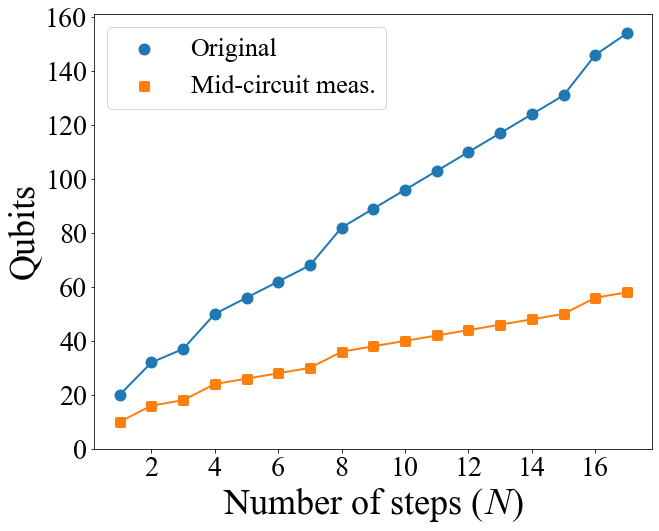

In [11]:
Nmax= 17

orig_qubits= np.arange(Nmax)
new_qubits= np.arange(Nmax)

for N in range(1, Nmax+1):
    orig_qubits[N-1]= qubit_count_original(N, nI)
    new_qubits[N-1]= qubit_count_new(N, nI)

    print('N: %d,    ' %(N) + 'orig: ' + str(orig_qubits[N-1]) + ',     new: ' + str(new_qubits[N-1]))
    

plt.figure(figsize=(10, 8))
plt.rcParams['mathtext.fontset'] = 'cm'

plt.plot(np.arange(1, Nmax+1, 1), orig_qubits, linewidth= 2)
plt.plot(np.arange(1, Nmax+1, 1), new_qubits, linewidth= 2)
plt.scatter(np.arange(1, Nmax+1, 1), orig_qubits, linewidth= 3, marker='o', s=80, label='Original')
plt.scatter(np.arange(1, Nmax+1, 1), new_qubits, linewidth= 3, marker='s', s=80, label='Mid-circuit meas.')
plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 26))

plt.ylim(bottom=0)
plt.xlabel('Number of steps ($N$)', fontname= 'times new roman', fontsize= 36)
plt.ylabel('Qubits', fontname= 'times new roman', fontsize= 36)
plt.xticks(size= 28, fontname= 'times new roman')
plt.yticks(size= 28, fontname= 'times new roman')

save= False
if save:
    plt.savefig('./plots/fig4_qubit_count.pdf')
plt.show()

## Oberservables Data -- number of emissions (E) and hardest emission (θmax)

### Define statistical parameters for plotting

In [25]:
sim_shots= int(1e5)
mcmc_shots= int(1e7)
n_analytical= int(1e5)

if iP[0] == '100':
    n1_i= 1 # initial f1
    n2_i= 0 # initial f2
    
    gL= g_1
    f0= 1
elif iP[0] == '101':
    n1_i= 0 # initial f1
    n2_i= 1 # initial f2
    
    gL= g_2
    f0= 2

### Perform classical MCMC simulation for (E)

In [26]:
# Note: this data is already saved in the data directory. Skip this cell to use the saved data, or run this cell
# to recompute the classical MCMC.
Nmax= 2

import classical as cl

save= False

for N in range(1, Nmax + 1):
    emits= cl.MCMC(mcmc_shots, eps, g_1, g_2, n1_i, n2_i, N, save= save, verbose=False)

print('Done.')

Done.


### Compute analytical θmax for g12= 0.

In [27]:
# Note: this data is already saved in the data directory. Skip this cell to use the saved data, or run this cell
# to recompute the analytical θmax function.

import classical as cl

for N in range(1, 6):
            
    lnxList = [math.log(eps**((i+0.5) / n_analytical)) for i in range(0, n_analytical)]
    yLList = [cl.dsigma_d_t_max(lnx, math.log(eps)/N, gL, normalized=False) for lnx in lnxList]

    np.savez('./data/thetamax_analytical_N=%d_iP=f%d_points=%s' %(N, f0, '{:.0e}'.format(n_analytical)), lnxList, yLList)

print('Done.')

Done.


### Get simulation counts for the original QPS

In [15]:
# Note: this data is already saved in the data directory. Skip this cell to use the saved data, or run this cell
# for each N you want in the plot to get new simulation data.

import QuantumPartonShower as qpso

#iP= ['100']
N= 2

print('Beginning...')
qps1o= qpso.QuantumPartonShower(N, 1, g_1, g_2, 1, eps) # newest remeasurement
qc1o, qubits1o= qps1o.createCircuit(iP)
print('g= 1 circuit constructed.')

qps0o= qpso.QuantumPartonShower(N, 1, g_1, g_2, 0, eps) # newest remeasurement
qc0o, qubits0o= qps0o.createCircuit(iP)
print('g= 0 circuit constructed.\n')

print('Qubits: ' + str(qc0o.num_qubits))
print('Clbits: ' + str(qc0o.num_clbits))
print('Gates: ' + str(qc0o.count_ops()))

t1= time.time()
countsOld= qps1o.simulate('mps', shots=sim_shots)
print('g= 1 simulation finished.')
t2= time.time()
countsOld2= qps0o.simulate('mps', shots=sim_shots)
t3= time.time()
print('g= 0 simulation finished.\n')

print('\nN= %d' %(N))
print('Simulation g12= 1 time: %.6f' %(t2 - t1))
print('Simulation g12= 0 time: %.6f\n\n' %(t3 - t2))

Beginning...
generated circuit on 33 qubits
g= 1 circuit constructed.
generated circuit on 33 qubits
g= 0 circuit constructed.

Qubits: 33
Clbits: 0
Gates: OrderedDict([('ccx', 1099), ('x', 926), ('cry', 75), ('cx', 32), ('ch', 3)])
g= 1 simulation finished.
g= 0 simulation finished.


N= 2
Simulation g12= 1 time: 5.699784
Simulation g12= 0 time: 4.631842




### Save the counts data

In [16]:
np.save('./data/counts_OLD_%dstep_g12=1_iP=%s_shots=%s.npy' %(N, qps1o.ptype(iP[0]), '{:.0e}'.format(sim_shots)), countsOld)
np.save('./data/counts_OLD_%dstep_g12=0_iP=%s_shots=%s.npy' %(N, qps0o.ptype(iP[0]), '{:.0e}'.format(sim_shots)), countsOld2)

### Get simulation counts for QPS with mid-circuit measurements

In [48]:
# Note: this data is already saved in the data directory. Skip this cell to use the saved data, or run this cell
# for each N you want in the plot to get new simulation data.

import QuantumPartonShower_ReM as qpsc

#iP= ['100']
N= 2

print('Beginning...')
qps1= qpsc.QuantumPartonShower_MCM(N, 1, g_1, g_2, 1, eps)
qc1, qubits1= qps1.createCircuit(iP)
print('g= 1 circuit constructed.')

qps0= qpsc.QuantumPartonShower_MCM(N, 1, g_1, g_2, 0, eps)
qc0, qubits0= qps0.createCircuit(iP)
print('g= 0 circuit constructed.\n')

print('Qubits: ' + str(qc0.num_qubits))
print('Clbits: ' + str(qc0.num_clbits))
print('Gates: ' + str(qc0.count_ops()))

t1= time.time()
counts= qps1.simulate('mps', shots=sim_shots, position=False)
print('\ng= 1 simulation finished.')
t2= time.time()
counts2= qps0.simulate('mps', shots=sim_shots, position=False)
print('g= 0 simulation finished.')
t3= time.time()

print('\nN= %d' %(N))
print('Simulation g12= 1 time: %.6f' %(t2 - t1))
print('Simulation g12= 0 time: %.6f\n\n' %(t3 - t2))

Beginning...
g= 1 circuit constructed.
g= 0 circuit constructed.

Qubits: 19
Clbits: 21
Gates: OrderedDict([('ccx', 276), ('x', 244), ('cry', 46), ('cx', 44), ('measure', 4), ('reset', 4), ('ch', 4)])

g= 1 simulation finished.
g= 0 simulation finished.

N= 2
Simulation g12= 1 time: 255.850088
Simulation g12= 0 time: 207.509175




### Save the counts data

In [49]:
np.save('./data/counts_%dstep_g12=1_iP=%s_shots=%s.npy' %(N, qps1.ptype(iP[0]), '{:.0e}'.format(sim_shots)), counts)
np.save('./data/counts_%dstep_g12=0_iP=%s_shots=%s.npy' %(N, qps0.ptype(iP[0]), '{:.0e}'.format(sim_shots)), counts2)

### Plot E

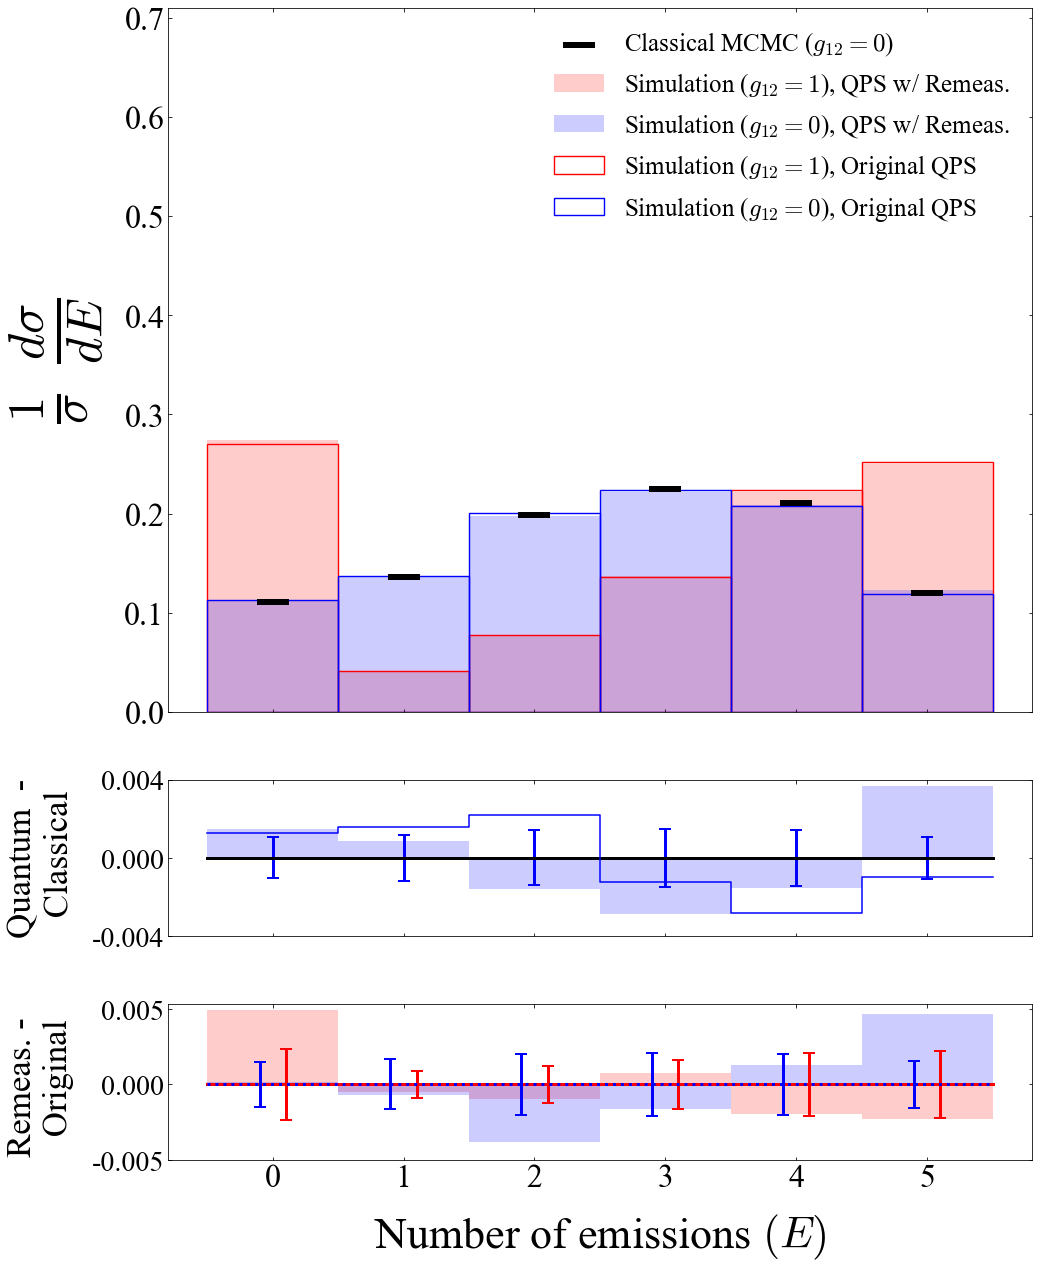

In [40]:
import plotting as pl

# Plots for each N are made separately, just change the value of N below.
# Ensure that the correct data is saved with the correct name; otherwise this cell might not work.
N= 5

# Choose with initial setup to plot '100' for 1-type, '101' for 2-type
iP= ['100']
if iP[0] == '100':
    n1_i= 1
    n2_i= 0
elif iP[0] == '101':
    n1_i= 0
    n2_i= 1

# Load data
counts= np.load('./data/counts_%dstep_g12=1_iP=%s_shots=%s.npy' %(N, qpsc.QuantumPartonShower_MCM.ptype(iP[0]), '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
counts2= np.load('./data/counts_%dstep_g12=0_iP=%s_shots=%s.npy' %(N, qpsc.QuantumPartonShower_MCM.ptype(iP[0]), '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
mcmc= np.load('./data/mcmc_%dstep_na=%d_nb=%d_shots=%s.npy' %(N, n1_i, n2_i, '{:.0e}'.format(mcmc_shots)))

try:
    countsOld= np.load('./data/counts_OLD_%dstep_g12=1_iP=%s_shots=%s.npy' %(N, qpsc.QuantumPartonShower_MCM.ptype(iP[0]), '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
    countsOld2= np.load('./data/counts_OLD_%dstep_g12=0_iP=%s_shots=%s.npy' %(N, qpsc.QuantumPartonShower_MCM.ptype(iP[0]), '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
    countsTup= (countsOld, countsOld2) 
except:
    countsTup=None

countsTup= (countsOld, countsOld2) 
# Make plot: set save=True to save the result as a pdf.
pl.master_plot_emissions(eps, g_1, g_2, N, 1, sim_shots, counts, counts2, mcmc=mcmc, save=False, old_alg=countsTup)

### Plot θmax

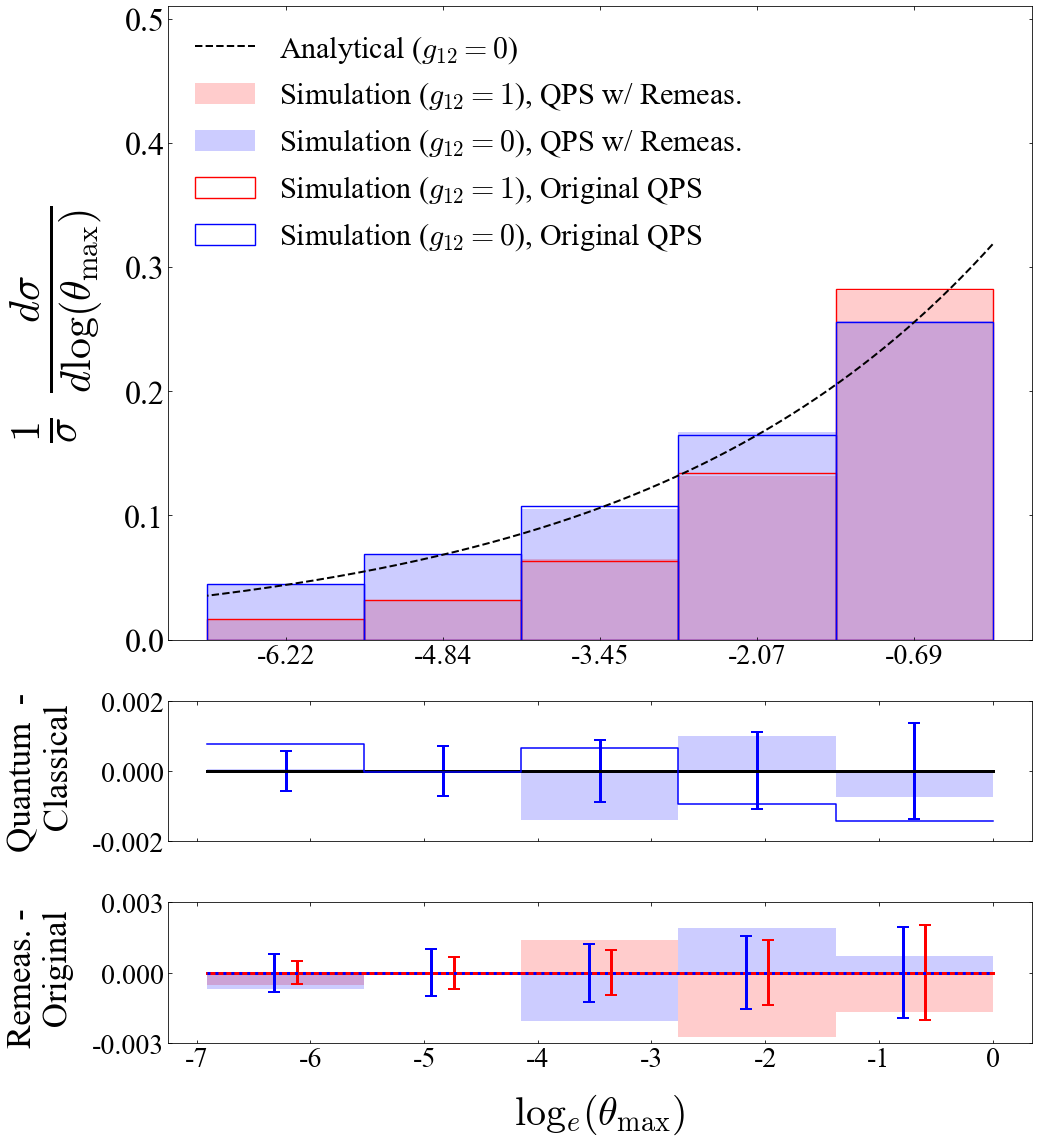

In [36]:
import plotting as pl

# Plots for each N are made separately, just change the value of N below.
# Ensure that the correct data is saved with the correct name; otherwise this cell might not work.
N= 5

# Choose with initial setup to plot '100' for 1-type, '101' for 2-type
iP= ['100']
if iP[0] == '100':
    n1_i= 1
    n2_i= 0
elif iP[0] == '101':
    n1_i= 0
    n2_i= 1

# Load data
counts= np.load('./data/counts_%dstep_g12=1_iP=%s_shots=%s.npy' %(N, qpsc.QuantumPartonShower_MCM.ptype(iP[0]), '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
counts2= np.load('./data/counts_%dstep_g12=0_iP=%s_shots=%s.npy' %(N, qpsc.QuantumPartonShower_MCM.ptype(iP[0]), '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
mcmc= np.load('./data/mcmc_%dstep_na=%d_nb=%d_shots=%s.npy' %(N, n1_i, n2_i, '{:.0e}'.format(mcmc_shots)))

try:
    countsOld= np.load('./data/counts_OLD_%dstep_g12=1_iP=%s_shots=%s.npy' %(N, qpsc.QuantumPartonShower_MCM.ptype(iP[0]), '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
    countsOld2= np.load('./data/counts_OLD_%dstep_g12=0_iP=%s_shots=%s.npy' %(N, qpsc.QuantumPartonShower_MCM.ptype(iP[0]), '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
    countsTup= (countsOld, countsOld2) 
except:
    countsTup=None

if iP[0] == '100':
    f0= 1
elif iP[0] == '101':
    f0= 2
npzfile = np.load('./data/thetamax_analytical_N=%d_iP=f%d_points=%s.npz' %(N, f0, '{:.0e}'.format(n_analytical)))
ax= npzfile['arr_0']
ay= npzfile['arr_1']

# Make plot: set save=True to save the result as a pdf.
pl.master_plot_thetamax(eps, g_1, g_2, N, 1, sim_shots, counts, counts2, analytical= (ax, ay), save=False, normalized=True, old_alg=countsTup)

## Count some gates using Qiskit

In [32]:
import QuantumPartonShower_ReM_GateCounting as qps_rg

eps= 0.001
g_1= 2
g_2= 1
nI= 1
iP= ['100'] # one 1-fermion

Nmax= 7

for N in range(2, Nmax):
    qps= qps_rg.QuantumPartonShower_GC(N, nI, g_1, g_2, 0, eps)
    qc, qubits= qps.createCircuit(iP, verbose=False)
    
    ops= qc.count_ops()
    cnots= 0
    if 'cx' in ops:
        cnots+= ops['cx']
    if 'ccx' in ops:
        cnots+= 6 * ops['ccx']
    if 'ch' in ops:
        cnots+= ops['ch']
    if 'cry' in ops:
        cnots+= 2 * ops['cry']

    print('Operations: ' + str(ops))
    print('Total: ' + str(cnots))
    print('Expected -- (Ucount, Ue, Uh, Up, R): ' + str(gate_counter(nI, N)))
    print('Expected total: ' + str(sum(gate_counter(nI, N))) + '\n')

Operations: OrderedDict([('ccx', 192), ('x', 177), ('cry', 32), ('cx', 16), ('measure', 4), ('reset', 4), ('h', 2), ('ry', 2)])
Total: 1232
Expected -- (Ucount, Ue, Uh, Up, R): (71, 32, 1105, 4, 20)
Expected total: 1232

Operations: OrderedDict([('ccx', 466), ('x', 421), ('cry', 68), ('cx', 55), ('measure', 6), ('reset', 6), ('h', 3), ('ry', 3)])
Total: 2987
Expected -- (Ucount, Ue, Uh, Up, R): (149, 88, 2708, 6, 36)
Expected total: 2987

Operations: OrderedDict([('ccx', 1038), ('x', 931), ('cry', 118), ('cx', 106), ('measure', 12), ('reset', 12), ('h', 4), ('ry', 4)])
Total: 6570
Expected -- (Ucount, Ue, Uh, Up, R): (305, 192, 6009, 8, 56)
Expected total: 6570

Operations: OrderedDict([('ccx', 1930), ('x', 1723), ('cx', 199), ('cry', 190), ('measure', 15), ('reset', 15), ('h', 5), ('ry', 5)])
Total: 12159
Expected -- (Ucount, Ue, Uh, Up, R): (500, 348, 11221, 10, 80)
Expected total: 12159

Operations: OrderedDict([('ccx', 3134), ('x', 2803), ('cx', 334), ('cry', 282), ('measure', 18),